<a href="https://colab.research.google.com/github/hirajya/Mask-Type-Classification-using-CNN/blob/main/Mask_Type_Classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask Type Classification using CNN
Classification model for mask types (cloth, n95, n95v, nfm, srg)

- cloth --> Cloth face mask images
- n95 --> N95 face mask images
- n95v --> N95 with Valve face mask images
- nfm --> No Face Mask images
- srg --> Surgical face mask images

In [55]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [56]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [76]:
IMAGE_SIZE = 300
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS= 5

In [58]:
path_directory = '/content/drive/MyDrive/mask_types_ds'

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path_directory,
    shuffle=True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1411 files belonging to 5 classes.


In [59]:
class_names = dataset.class_names
class_names

['cloth', 'n95', 'n95v', 'nfm', 'srg']

In [60]:
len(dataset)

45

In [61]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 300, 300, 3)
[2 3 1 0 1 2 0 0 2 0 2 1 3 2 2 2 1 0 1 2 0 1 2 1 0 3 2 2 0 3 2 0]


In [62]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch[0].shape)


(300, 300, 3)


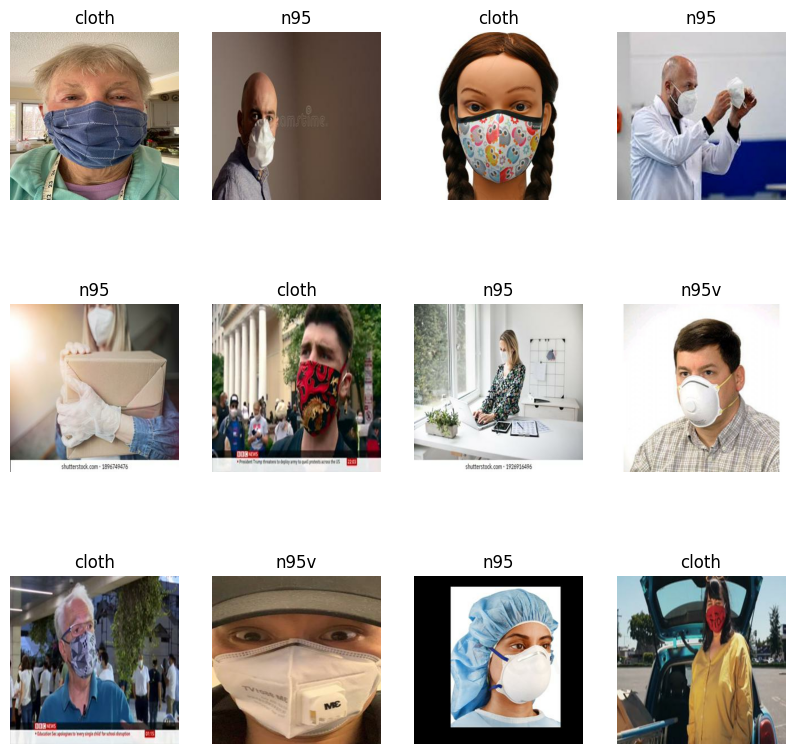

In [63]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

Splitting for training, validation, & testing

In [64]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds


In [65]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [66]:
len(train_ds)

36

In [67]:
len(val_ds)

4

In [68]:
len(test_ds)

5

Optimizing performance

In [69]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Scaling the dataset

In [70]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/300)
])

Using data augmentation in the dataset

In [71]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [72]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')

])

model.build(input_shape=input_shape)

In [73]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (32, 300, 300, 3)         0         
                                                                 
 sequential_13 (Sequential)  (32, 300, 300, 3)         0         
                                                                 
 conv2d_34 (Conv2D)          (32, 298, 298, 32)        896       
                                                                 
 max_pooling2d_33 (MaxPoolin  (32, 149, 149, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (32, 147, 147, 64)        18496     
                                                                 
 max_pooling2d_34 (MaxPoolin  (32, 73, 73, 64)         0         
 g2D)                                                

In [74]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [77]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/5
36/36 [==============================] - 309s 9s/step - loss: 1.3100 - accuracy: 0.3357 - val_loss: 1.3033 - val_accuracy: 0.3047
Epoch 2/5
36/36 [==============================] - 337s 9s/step - loss: 1.1843 - accuracy: 0.4586 - val_loss: 1.2725 - val_accuracy: 0.4531
Epoch 3/5
36/36 [==============================] - 318s 9s/step - loss: 1.1735 - accuracy: 0.4737 - val_loss: 1.3128 - val_accuracy: 0.3516
Epoch 4/5
36/36 [==============================] - 342s 9s/step - loss: 1.1213 - accuracy: 0.4960 - val_loss: 1.3497 - val_accuracy: 0.4141
Epoch 5/5
36/36 [==============================] - 330s 9s/step - loss: 1.1520 - accuracy: 0.4880 - val_loss: 1.1119 - val_accuracy: 0.4922


In [78]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 21s 4s/step - loss: 1.0666 - accuracy: 0.4625


In [79]:
scores

[1.0666147470474243, 0.4625000059604645]

In [80]:
history

In [81]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 36}

In [82]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [83]:
len(history.history['accuracy'])

5

In [84]:
history.history['accuracy']

[0.3357079327106476,
 0.4585930407047272,
 0.47373107075691223,
 0.49599286913871765,
 0.48797863721847534]

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

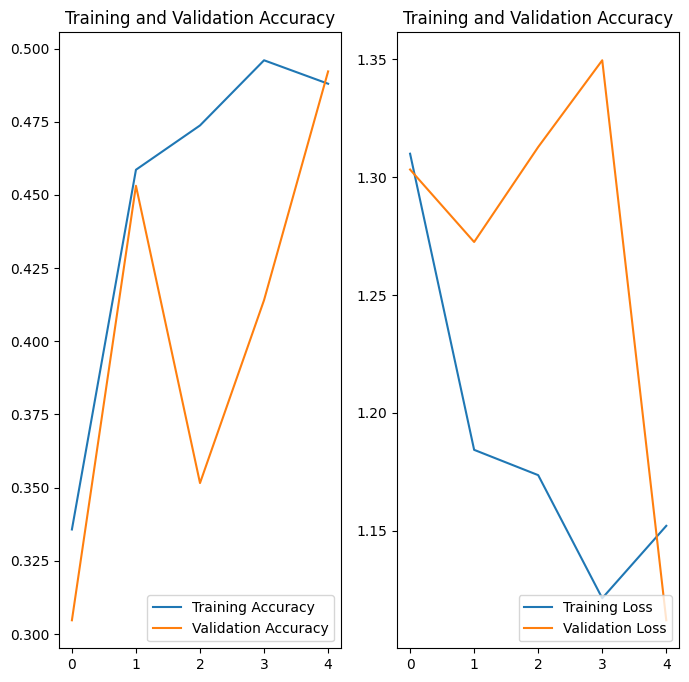

In [87]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

first image to predict
1/1 [==============================] - 3s 3s/step
prediction  [0.5130414  0.2552222  0.12446777 0.10619305 0.00107547]
actual label:  cloth
predicted label:  0


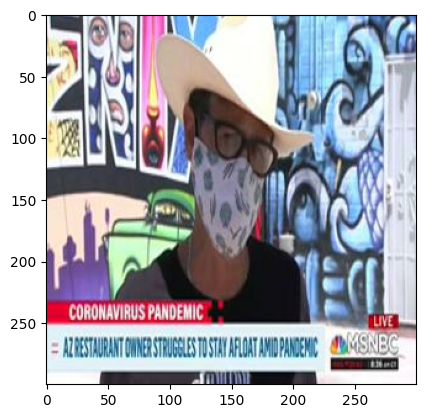

In [89]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0]

  print("first image to predict")
  plt.imshow(first_image)

  batch_prediction = model.predict(images_batch)
  print("prediction ",batch_prediction[0])
  print("actual label: ", class_names[first_label])
  print("predicted label: ",np.argmax(batch_prediction[0]))



In [90]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0) # create a batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 [==============================] - 0s 67ms/step


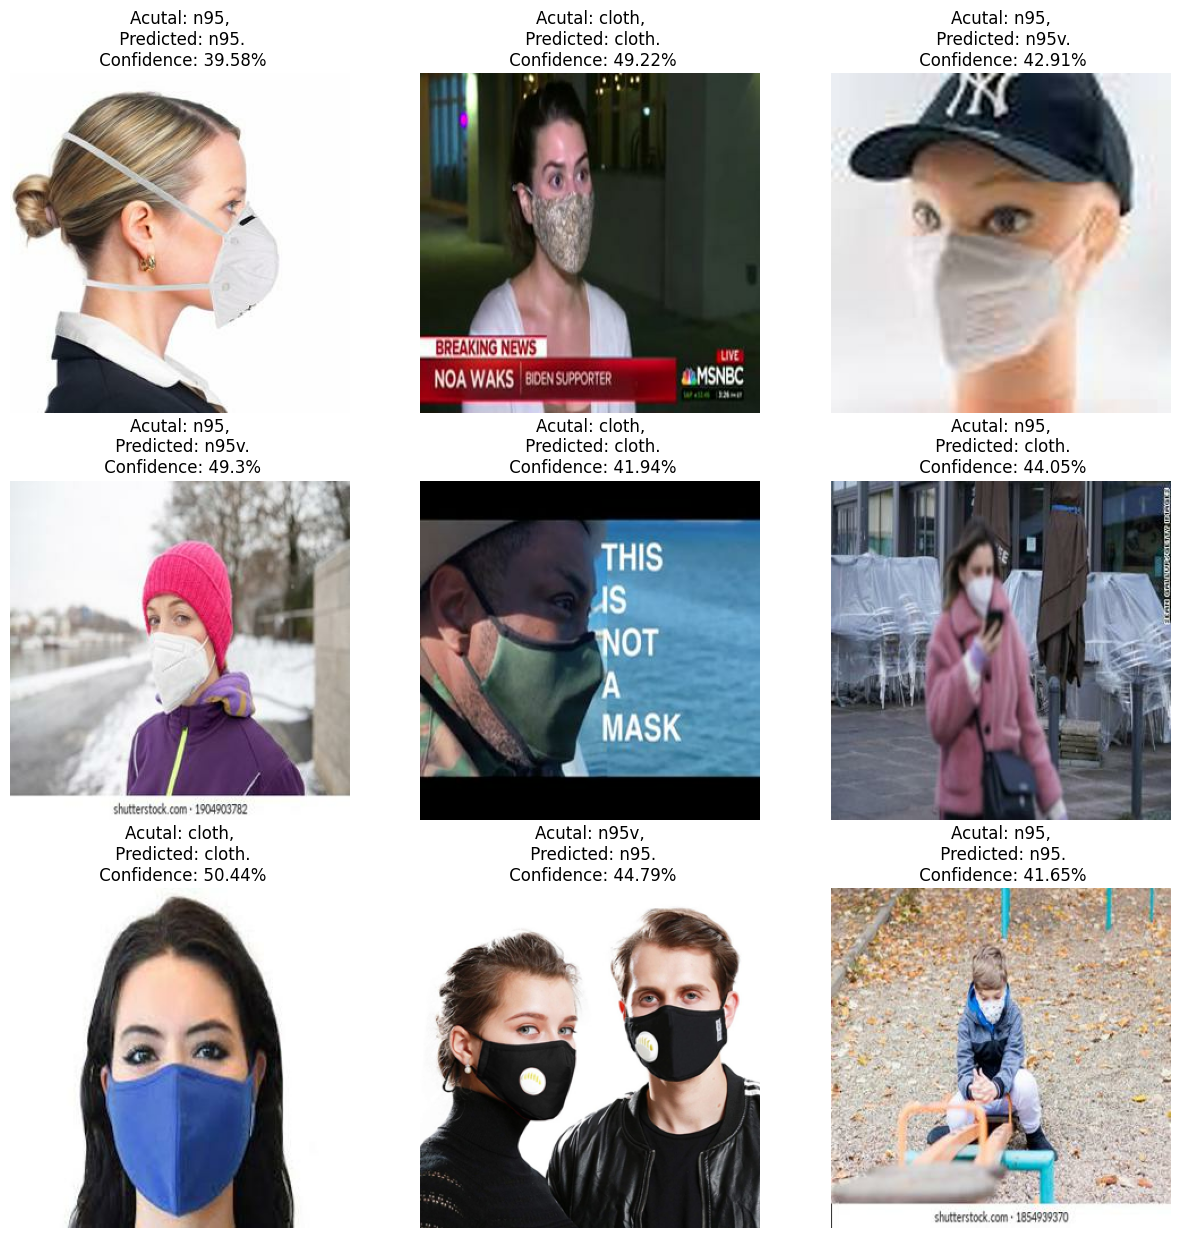

In [91]:
plt.figure(figsize = (15, 15))

for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Acutal: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")


    plt.axis("off")

In [92]:
model_version=1
model.save(f"/content/drive/MyDrive/mask_types_ds/model/{model_version}")

In [93]:
import os
os.listdir("/content/drive/MyDrive/mask_types_ds/model")

['1']

In [94]:
import os
max([ int(i) for i in os.listdir("/content/drive/MyDrive/mask_types_ds/model")])

1

In [95]:
import os
max([ int(i) for i in os.listdir("/content/drive/MyDrive/mask_types_ds/model")]) + 1 # knowing the next model version

2

In [ ]:
# model_version=max([ int(i) for i in os.listdir("/content/drive/MyDrive/mask_types_ds/model")]) + 1
# model.save(f"/content/drive/MyDrive/mask_types_ds/model/{model_version}")